# Hand Gesture Recognition

By Jonathan Christyadi - 502705

Github Repository: https://github.com/christyadi/hand-gesture-CNN

## Introduction
Hand gesture recognition is a critical component of human-computer interaction, enabling intuitive control of devices using natural hand movements. This project focuses on the development and evaluation of a Neural Network model especially VG-166 for recognizing various hand gestures, utilizing a comprehensive dataset provided by the Universidad de Alicante. The dataset comprises real images, synthetic images, and scene descriptions, designed to train and evaluate hand gesture detection methods.

More info about the model: https://www.geeksforgeeks.org/vgg-16-cnn-model/

# Dataset Overview
The original images and videos were recorded at a resolution of 1,920 x 1,080 pixels. However, for performance and accuracy reasons, the images were scaled down to a spatial resolution of 224 x 224 pixels.

Dataset sources: https://www.dlsi.ua.es/~jgallego/datasets/gestures/


Gesture Categories and Dataset Summary
The dataset encompasses the following gesture categories:

- Point: Images of pointing gestures.
- Drag: Images including drag gestures.
- Loupe: Samples including loupe gestures.
- Pinch: Sequences of dynamic pinch gestures.
- None: Samples where no hand appears.

The dataset is highly suitable for training robust hand gesture recognition models due to its quality and diversity, as evidenced by several key factors:

1. Variety in Real Images: The real images dataset includes frames extracted from videos recorded in varied environments, including indoor and outdoor scenes, with different lighting conditions and backgrounds.
2. Balanced Gesture Representation: The dataset ensures balanced representation of each gesture category, with a comparable number of samples for point, drag, loupe, pinch, and none. 
3. Comprehensive Annotations: The dataset provides detailed annotations, including bounding boxes for hand positions, fingertips, and objects pointed to.
4. High-Quality Image Resolution: Although the original images were recorded at a high resolution of 1,920 x 1,080 pixels, they were downscaled to 224 x 224 pixels for practical reasons. 

Nevertheless, there are some limitation about the data, for example: the skin tone color of the hand in the pictures. Most of the skin color in the images are either white or brown but does not include black. 

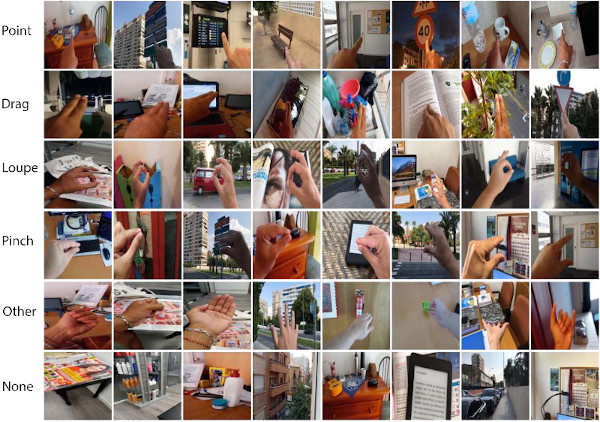

# Project Objectives
This project aims to build a robust CNN model capable of accurately recognizing hand gestures from images, leveraging the rich and varied dataset provided. The model will be trained, validated, and tested on real data to ensure generalization across different environments and conditions. Additionally, the project includes a data preprocessing pipeline, data augmentation strategies, and a detailed evaluation process to measure the model's performance.

## Imports Libraries

In [1]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split


# Data Preprocessing

First I want to specify the set of labels (gestures) that the model will be trained to recognize and sets up the directory for accessing the images and their annotations. 

In [2]:
# Define the classes
labels_to_include = ['Drag', 'Loupe', 'Point', 'Scale', 'None']

# Define the paths
dataset_path = r'dataset'
annotation_path = os.path.join(dataset_path, 'annotations')
image_path = os.path.join(dataset_path, 'images')

Since the images and annotations are in a different folder, I need to combine both file. Also, I need to extract the relevant information from the annotation file such as the box x and y coordinates. 

In [3]:
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    bndboxes = []
    
    # Derive label from the annotation file path
    annotation_dir = os.path.dirname(annotation_file)
    label = os.path.basename(annotation_dir)
    
    if label not in labels_to_include:
        return None, None, None

    for obj in root.findall('object'):
        name = obj.find('name').text
        
        # Skip objects not in labels_to_include
        if name not in labels_to_include:
            continue

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bndboxes.append((xmin, ymin, xmax, ymax))

    filename = root.find('filename').text
    return filename, bndboxes, label

## Data Preparation

Defines a dataset class that can be used with PyTorch's data loading utilities. Then images are resized to a standard size of 224x224 pixels, and optional transformations can be applied. The class handles cases where there are no annotations (e.g., 'None' class) by returning an empty list for bounding boxes.


In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        annotation = self.annotations[idx]
        
        if annotation[1] is None:
            bndboxes = []
        else:
            bndboxes = annotation[1]

        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)
        
        return image, bndboxes, annotation[2]  # image, annotations, label

## Data Loading

Reads images and their corresponding annotations from the dataset. This function iterates over the labels, reads images from the respective directories, and parses their annotations. For the 'None' class, it directly reads images without looking for annotations. For other classes, it reads both images and their XML annotations. 

In [5]:
def load_images_and_annotations():
    images = []
    annotations = []

    for label in labels_to_include:
        image_folder = os.path.join(image_path, label)

        if label == 'None':
            # For images in the None folder (no annotations)
            if os.path.exists(image_folder):
                for image_file in os.listdir(image_folder):
                    image_filepath = os.path.join(image_folder, image_file)
                    image = cv2.imread(image_filepath)
                    if image is not None:
                        images.append(image)
                        annotations.append((image_file, torch.empty((0, 4)), label))
                    else:
                        print(f"Image not found or cannot be read: {image_filepath}")
            else:
                print(f"Image folder does not exist: {image_folder}")
        else:
            annotation_folder = os.path.join(dataset_path, 'annotations', label)
            if os.path.exists(annotation_folder):
                for annotation_file in os.listdir(annotation_folder):
                    annotation_filepath = os.path.join(annotation_folder, annotation_file)
                    filename, bndboxes, parsed_label = parse_annotation(annotation_filepath)
                    if filename:
                        image_filepath = os.path.join(image_folder, filename)
                        image = cv2.imread(image_filepath)
                        if image is not None:
                            images.append(image)
                            annotations.append((filename, bndboxes, parsed_label))  # Attach bounding boxes properly
                        else:
                            print(f"Image not found or cannot be read: {image_filepath}")
                    else:
                        print(f"Failed to parse annotation: {annotation_filepath}")
            else:
                print(f"Annotation path does not exist: {annotation_folder}")

    return images, annotations

## Data Exploratory

First I need to organize annotations into separate groups based on their labels. Then, I want to iterate through the annotations, and for each annotation, it adds it to the appropriate list in the dictionary based on its label.

In [6]:
# Group annotations by class
def group_annotations_by_class(annotations):
    grouped_annotations = {label: [] for label in labels_to_include}
    for annotation in annotations:
        filename, bndboxes, label = annotation
        if label in grouped_annotations:
            grouped_annotations[label].append(annotation)
    return grouped_annotations

Then I want to visualizes random sample images from each class with their bounding boxes. It then creates a plot with subplots for each label. For each label, it randomly selects an annotation, retrieves the corresponding image, draws bounding boxes on the image, and displays it.

In [7]:
# Function to plot random samples from each class
def plot_random_samples(images, annotations):
    grouped_annotations = group_annotations_by_class(annotations)
    fig, axes = plt.subplots(1, len(labels_to_include), figsize=(20, 5))
    for i, label in enumerate(labels_to_include):
        ax = axes[i]
        if label in grouped_annotations and len(grouped_annotations[label]) > 0:
            random_annotation = random.choice(grouped_annotations[label])
            filename, bndboxes, _ = random_annotation
            image_idx = [i for i, ann in enumerate(annotations) if ann == random_annotation][0]
            image = images[image_idx]

            # Draw bounding boxes if they exist
            if bndboxes is not None:
                for (xmin, ymin, xmax, ymax) in bndboxes:
                    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Draw in BGR format
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            ax.imshow(image_rgb)
            ax.set_title(label)
            ax.axis('off')
        else:
            ax.set_title(f'No {label}')
            ax.axis('off')
    plt.show()

Here is a transformer code and used to convert Image into a Pytorch tensor (input toa  neural network). 
Normalization helps in faster convergence during training by ensuring the pixel values are within a specific range, in this case from 0 - 255 to 0.0 to 1.0.
- ToTensor() ensures the image is represented numerically as a tensor.
- Normalize() ensures the input data has a consistent numeric range and distribution, which helps in training the neural network more effectively.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Now I load the images and their annotations from the directory. Then the resulting images and annotations are stored in a list called images and annotations.

In [9]:
images, annotations = load_images_and_annotations()

## Visualization

Now I want to get a random images and its label to proof that each images and its annotations are correctly loaded.

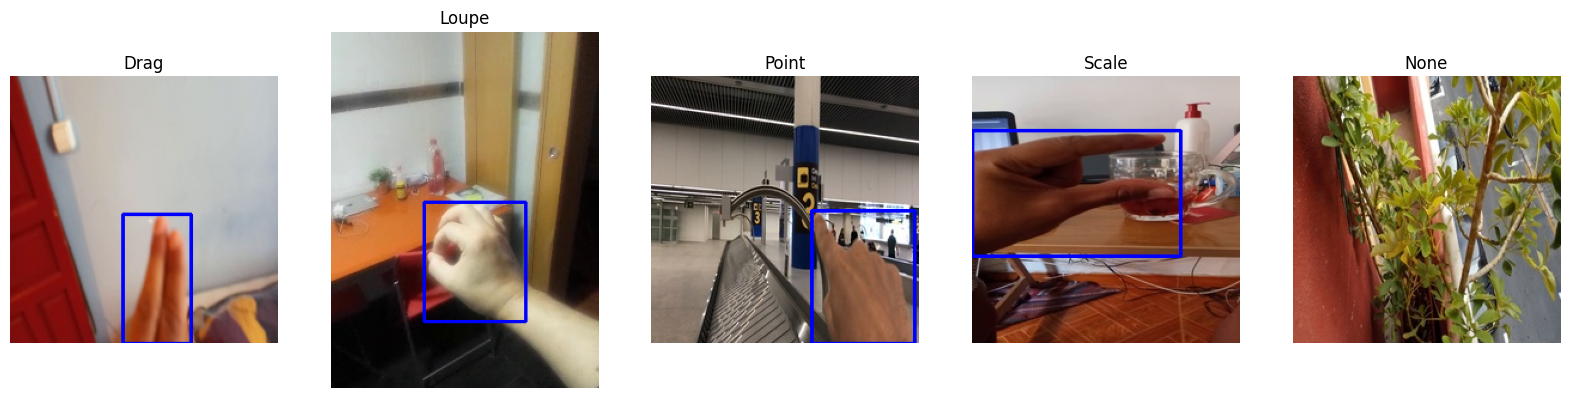

In [10]:
plot_random_samples(images, annotations)

## Visualizes the distribution of images across different classes in the dataset.

I want to check the images distribution from each classes. The total distribution should be somewhat or close to equal. In this case, the data distribution are equally spreaded around 2000 images and annotation from each classes.

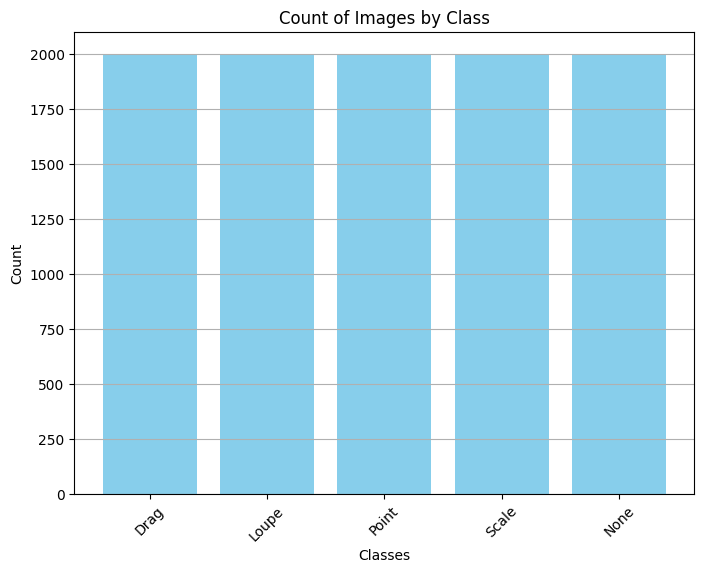

In [11]:
# Function to plot the count of each class
def plot_class_counts(annotations):
    labels = [annotation[2] for annotation in annotations if annotation[2] in labels_to_include]
    label_counts = {label: labels.count(label) for label in labels_to_include}

    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Count of Images by Class')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.show()

plot_class_counts(annotations)

Now I want to load the images and annotations into one variable called `dataset`.

In [12]:
dataset = CustomDataset(images, annotations, transform=transform)


In [13]:
def custom_collate_fn(batch):
    images = []
    bndboxes = []
    labels = []

    for item in batch:
        images.append(item[0])
        bndboxes.append(item[1])
        labels.append(item[2])

    # Stack images into a single tensor
    images = torch.stack(images, dim=0)

    return images, bndboxes, labels

# Data Splitting

The dataset (images and annotations) is split into training and validatio sets using train_test_split from sklearn. The distribution are 80%-20% respectively. 

In [14]:
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state=42)

Now to train pytorch's neural network, I need to make pytorch's dataset and dataloder, to create pytorch's dataset objects (train_dataset, val_dataset). The difference between dataset and dataloader is, dataset holds all the data you want to work with, while the dataloader helps manage and deliver that data in a structured manner to the machine learning model, making the learning process smoother and more efficient.

In [15]:
batch_size = 32

In [16]:
train_dataset = CustomDataset(train_images, train_annotations, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

To create PyTorch DataLoader objects (train_dataloader, val_dataloader, test_dataloader) for efficient batch processing during model training and evaluation. Ensures randomness in the order of batches during training (shuffle=True for train_dataloader).

In [17]:
# Define validation dataset and dataloader
val_dataset = CustomDataset(val_images, val_annotations, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)


# Modelling

In this project, I want to try to use a more advance neural network, called VGG-16. 

# Importing Libraries for modelling purposes

I will use neural network libraries by pytorch. I use this library because it support cuda training which greatly improve training time compared to normal training using CPU. I tried other library such as tensorflow, however in my machined it did not support cuda.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision import models


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Here I initialized the model design of VGG-16. The model was pre trained using ImageNet images across 1000 classes, but I modified the architecture and re-train the model using my own images and the corresponding labels. 

In [20]:
num_classes = len(labels_to_include)

# Define the VGG-16 based model
class VGG16Model(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Model, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        # Replace the last fully connected layer
        self.vgg.classifier[6] = nn.Linear(self.vgg.classifier[6].in_features, num_classes)
    
    def forward(self, x):
        return self.vgg(x)

Here I initialized the model, optimizer, and loss fuctions. The optimizer works to updates the model parameters based on the computed gradients to minimize the loss. For the criterion or loss function it computes the difference between predicted outputs and actual targets, providing a measure of how well the model is performing.

In [21]:
# Initialize model, loss function, and optimizer
# Initialize the model
model = VGG16Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

C:\Users\jochr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jochr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Here I initialized a list to gather the losses and accuracies values throughout each training iterations. These list then will be used to make graphs. 

In [22]:
train_losses = []
val_losses = []
val_accuracies = []


This training loop iteratively improves the VGG-16 model across multiple epochs (epoch represents one complete cycle of using the entire dataset to train and update a machine learning model, ensuring it learns patterns and optimizes performance based on the training data). In this case there are 8000 training data divided into 32 batch size which equal 250 iterations/ steps. Every 100 iterations, it prints the accuracy and validation loss value. Validation loss and accuracy are computed to assess how well the model generalizes to unseen data. The model takes alot of time to train, and I believe that 5 epochs are the sweet spot.

In [23]:
epochs = 5
for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    for i, (images, bndboxes, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 9:  # Print every 10 mini-batches
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    # Validation after each epoch
    model.eval()  
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, bndboxes, labels in val_dataloader:
            images = images.to(device)
            labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Compute validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Total number of labels
            total += labels.size(0)
            
            # Total correct predictions
            correct += (predicted == labels).sum().item()

        # Average validation loss
        val_loss /= len(val_dataloader)
        val_accuracy = (correct / total) * 100
        print(f'Validation Loss after epoch {epoch + 1}: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Save metrics for plotting
        train_losses.append(running_loss / len(train_dataloader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

print('Finished Training')

Epoch [1/5], Step [10/250], Loss: 1.4374
Epoch [1/5], Step [110/250], Loss: 3.7415
Epoch [1/5], Step [210/250], Loss: 0.8133
Validation Loss after epoch 1: 0.0421, Accuracy: 98.95%
Epoch [2/5], Step [10/250], Loss: 0.0190
Epoch [2/5], Step [110/250], Loss: 0.3164
Epoch [2/5], Step [210/250], Loss: 0.4522
Validation Loss after epoch 2: 0.0367, Accuracy: 99.00%
Epoch [3/5], Step [10/250], Loss: 0.0112
Epoch [3/5], Step [110/250], Loss: 0.3723
Epoch [3/5], Step [210/250], Loss: 0.4123
Validation Loss after epoch 3: 0.1497, Accuracy: 95.25%
Epoch [4/5], Step [10/250], Loss: 0.0226
Epoch [4/5], Step [110/250], Loss: 0.2499
Epoch [4/5], Step [210/250], Loss: 0.1002
Validation Loss after epoch 4: 0.0280, Accuracy: 99.45%
Epoch [5/5], Step [10/250], Loss: 0.0052
Epoch [5/5], Step [110/250], Loss: 0.2191
Epoch [5/5], Step [210/250], Loss: 0.7256
Validation Loss after epoch 5: 0.0604, Accuracy: 98.05%
Finished Training


# Evaluation

Now I want to assess the performance of the trained model using various metrics and methods. This section helps me in understanding how well the model generalizes to unseen data and identifies areas where improvements might be needed. 

## Loss and Accuracy Overtime

Now I want to see the validation, training losses and the accuracy throughout each epochs, this can be useful to gather insights about the model.

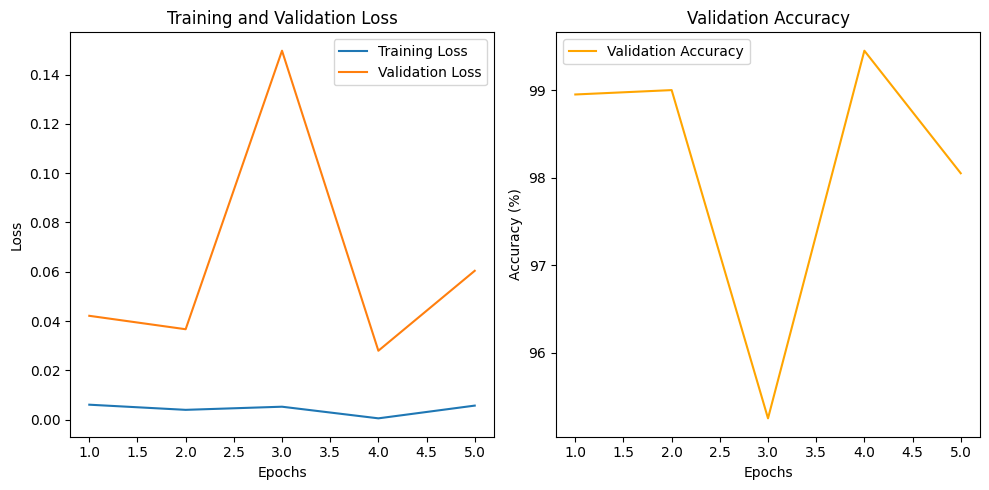

In [24]:
# Plotting the training progress
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Based on the graph above, it can be observed that:

1. Generally, lower validation loss indicates better model performance. Epochs 1, 2, and 4 have relatively low validation losses, suggesting better performance during these epochs. Epoch 3 shows a significantly higher loss, indicating potential overfitting or issues in model generalization.

2. Low training losses indicate that the model is fitting the training data well. The consistency in training losses across epochs suggests stable learning.

3. Higher validation accuracies generally indicate better model performance on unseen data. Epoch 4 has the highest accuracy, followed closely by Epoch 2, suggesting these epochs produced models with strong generalization ability. Epoch 3 shows lower accuracy, which aligns with its higher validation loss.

## Classification Report

A classification report provides a concise summary of the key performance metrics for a classification model. 

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, bndboxes, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Append to lists for confusion matrix and classification report
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    return all_labels, all_predictions


In [26]:
# Evaluate the model
val_labels, val_predictions = evaluate_model(model, val_dataloader)

# Compute classification report
class_report = classification_report(val_labels, val_predictions, target_names=labels_to_include)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

        Drag       1.00      0.99      0.99       410
       Loupe       0.99      0.99      0.99       393
       Point       0.99      0.94      0.96       395
       Scale       0.97      0.99      0.98       415
        None       0.95      0.99      0.97       387

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In summary, based off the classification report:

1. The overall accuracy of 98% indicates that the model performs very well across all classes in the validation dataset.
2. The model shows high precision, recall, and F1-score across all classes, indicating robust performance in classifying hand gestures.
3. Classes like Drag, Loupe, and Scale have particularly high precision and recall, suggesting the model effectively identifies these gestures with minimal false positives and negatives.

## Confusion Matrix

Confusion matrix is a powerful tool for evaluating the performance of a classification model. It provides a detailed breakdown of how the model's predictions compare to the actual labels. Hence, I would like to see the detailed breakdown of it. 

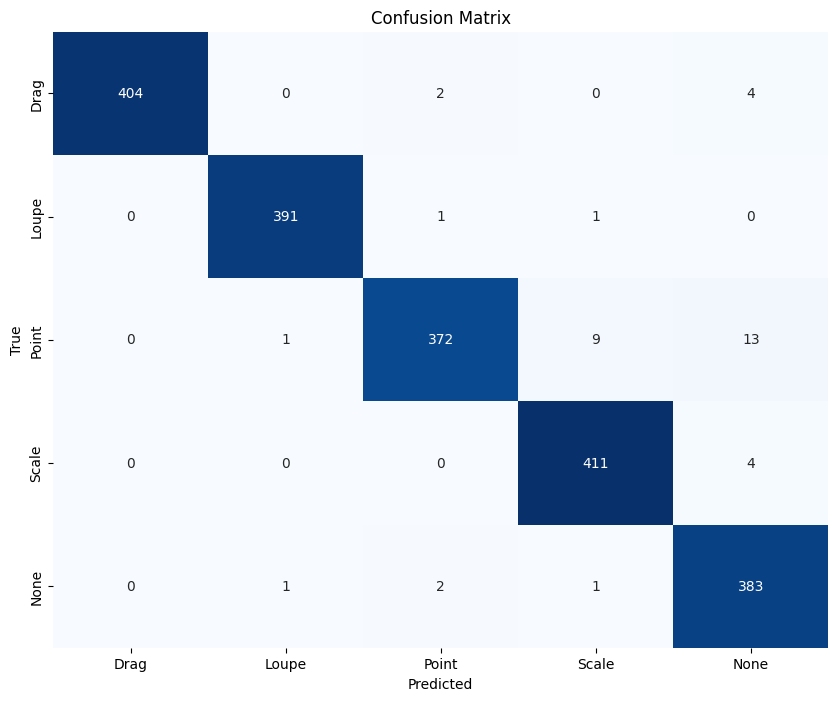

In [27]:
# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels_to_include, yticklabels=labels_to_include)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Based on the confusion matrix, the diagonal elements (the blues) are generally high, indicating that the model is correctly predicting these classes well. However, there are some moderate values off the diagonal, suggesting some misclassifications.

# Conclusion


Based on the analysis of the confusion matrix, classification report, and epoch training graphs for the hand gesture recognition model, here are the final conclusions:

Final Conclusion:
- Model Performance: The hand gesture recognition model based on VGG-16 architecture, trained and evaluated on a diverse dataset, demonstrates robust performance with high accuracy and minimal misclassifications.
- Generalization: The model shows strong generalization capabilities across different hand gesture categories, as evidenced by high precision, recall, and F1-scores across all classes.
- Training Stability: The training process was stable, with consistent decreases in loss and improvements in accuracy throughout the epochs, indicating effective learning and generalization.

## Potential Improvements

1. Introduce more diverse data augmentation techniques to expose the model to variations in input data during training, potentially improving generalization. Such as random rotations, translations, and color jitter to augment the dataset further. 

2. Explore different hyperparameters (e.g., batch size, optimizer parameters) to find optimal settings for your specific dataset and model architecture. I tried to use GridSearchCV to find the best parameters, however the result were horrible. I need more time and explore deeper into this. 

3. Reducing or increasing the epochs might help to mitigate overfitting. If validation metrics stabilize or degrade after a certain point, it's a sign that the model may not benefit significantly from additional epochs.

In [29]:
# import pickle
# torch.save(model.state_dict(), 'test_model/hand_gesture_model_VGG16.pth')

# model_metadata = {
#     'model_architecture': 'VGG16',
#     'input_size': (224, 224),
#     'num_classes': len(labels_to_include),
#     'class_labels': labels_to_include,
#     'batch_size': 64,
#     'learning_rate': 0.0001,
#     'num_epochs': epochs,
#     'optimizer': 'Adam',
#     'date': '2023-06-26',
#     'accuracy': val_accuracy,
#     'loss': val_loss
# }
# with open('VGG-16_metadata.pkl', 'wb') as f:
#     pickle.dump(model_metadata, f)
# # torch.save(model_metadata, 'test_model/hand_gesture_model_VGG16_metadata.pth')